# Exoplanets - Coursework Submission: Exercise 2
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

21st June 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Exoplanets* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Exoplanets - Coursework Assignment](Exoplanets.pdf). The associated report can be found here: [Exoplanets - Coursework Report](report/exo_sd2022_report.pdf).


## Set-Up

### Installations

In [44]:
# Make sure necessary packages are installed

!pip install statsmodels
!pip install numpy
!pip install pandas
!pip install matplotlib
!python -m pip install lightkurve --upgrade
!pip install astropy
!pip install george
!pip install dynesty




### Imports and Settings

In [73]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import george 
import emcee
from george import kernels, GP
from scipy import optimize
from astropy.timeseries import LombScargle
from utils.plot_tool import plot_time_series_all, plot_periodograms_all, plot_correlations, plot_long_term_trend, plot_stellar_gp_results, plot_gp_predict
from utils.gp_tool2 import multi_stellar_gp, K_qp, K_qp_multi, gp_predict, keplerian_model_0, keplerian_model_1, keplerian_model_2

# Set up plotting style
plt.style.use('sd2022.mplstyle')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Gill Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' 
sd2022_orange = '#ff8243'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
sd2022_bronze =  '#b08d57'

color_secondary = sd2022_red
color_model = sd2022_green
color_model2 = sd2022_pink


### Load Data

In [46]:
# Load the Doppler radial velocity data
data_path = '../data/ex2_RVs.txt'
df_full = pd.read_csv(data_path, delimiter=',', header=None, names=['time', 'rv', 'rv_err', 'fwhm', 'fwhm_err', 'bispan', 'bispan_err', 'instrument']).drop([0,1,2,3,4,5,6,7]).reset_index(drop=True)
df_full['time'] = df_full['time'].astype(float)
df_full['drv'] = df_full['rv'].diff()
df_full['drv_err'] = np.sqrt(df_full['rv_err']**2 + df_full['rv_err'].shift()**2)
print("Instruments: ", df_full['instrument'].unique())

df = df_full[df_full['instrument'] != 'INST1']
df.head()

Instruments:  ['INST1' 'INST2' 'INST3' 'INST4']


time        rv   rv_err    fwhm  fwhm_err  bispan  bispan_err  \
43  5471.805627  0.019196  0.00027  5.4930    0.0006  0.1593      0.0006   
44  5476.916440  0.020666  0.00019  5.5031    0.0004  0.1564      0.0004   
45  5479.956295  0.022656  0.00019  5.5066    0.0004  0.1565      0.0004   
46  5499.951510  0.019916  0.00020  5.5010    0.0004  0.1583      0.0004   
47  5777.049420  0.016546  0.00021  5.5223    0.0005  0.1494      0.0005   

   instrument      drv   drv_err  
43      INST2  0.03093  0.002495  
44      INST2  0.00147  0.000330  
45      INST2  0.00199  0.000269  
46      INST2 -0.00274  0.000276  
47      INST3 -0.00337  0.000290

## Question 3 & 4

In [47]:
# === Stellar Activity & Planetary Signals ====================================

# Data preparation
factor = 1
df_use = df
time = df_use['time'].values
rv = df_use['rv'].values * factor
rv_err = df_use['rv_err'].values  * factor
fwhm = df_use['fwhm'].values * factor
fwhm_err = df_use['fwhm_err'].values * factor
bispan = df_use['bispan'].values * factor
bispan_err = df_use['bispan_err'].values * factor
y = np.vstack([rv, fwhm, bispan])
yerr = np.vstack([rv_err, fwhm_err, bispan_err])
jitters = np.array([1e-6, 1e-5, 1e-6]) 

# Set prior bounds for the GP analysis
params_shared_bounds = [(21, 41), (0, 20), (250, 2500)] # P, lambda_p, lambda_e
params_individual_bounds = [
    [(0, 1)], # h_rv
    [(0, 10)], # h_fwhm
    [(0, 1)] # h_bispan
]

kepler_params_bounds_1 = [
    (2, 895/6),  # P1 (period for planet 1)
    (0, 9/1000),   # K1 (semi-amplitude for planet 1)
    (time.min(), time.min()+895/6),  #  phi (phase for planet 1)
]

kepler_params_bounds_2 = [
   (2, 895/6),   # P1 (period for planet 1)
    (0, 9/1000),   # K1 (semi-amplitude for planet 1)
    (time.min(), time.min()+895/6),  # t_c1 (time of periastron passage for planet 1)
    (2, 895),  # P1 (period for planet 1)
    (0, 9/1000),   # K2 (semi-amplitude for planet 2)
    (time.min(), time.min()+895)   # phi (phase for planet 2)
]

Simplified Keplerian model run: 
Running Nested Sampling for 1 planets...


18561it [05:14, 59.01it/s, +500 | bound: 238 | nc: 1 | ncall: 504177 | eff(%):  3.784 | loglstar:   -inf < 494.180 <    inf | logz: 461.700 +/-  0.231 | dlogz:  0.000 >  0.010]


Log-evidence: 461.70 +/- 0.24
Weighted Mean: [3.53976937e+01 6.07463630e+00 1.34407179e+03 1.07787079e-01
 3.59683338e+00 1.31308612e-01 5.08958203e+00 2.49753559e-03
 5.55871445e+03]
Weighted Standard Deviation: [8.32871466e-02 3.08753687e+00 3.41459634e+02 7.64294025e-02
 1.23619625e+00 5.97070215e-02 1.97456728e-03 2.82147409e-04
 1.83698779e-01]
MAP Estimate: [3.54353903e+01 3.50932702e+00 1.17033147e+03 5.29925275e-02
 2.33383223e+00 7.85767191e-02 5.08977261e+00 2.59364326e-03
 5.55869373e+03]
$P_{rot}$ = 35.39962 with 68% credible interval [-0.08521, +0.08192] and 95% credible interval [-0.16954, +0.14899]
$\lambda_p$ = 5.03313 with 68% credible interval [-1.18664, +3.11667] and 95% credible interval [-1.83413, +10.92143]
$\lambda_e$ = 1359.59853 with 68% credible interval [-357.55875, +311.86962] and 95% credible interval [-731.27577, +644.22565]
$h_{RV}$ = 0.08743 with 68% credible interval [-0.03699, +0.07375] and 95% credible interval [-0.05454, +0.22421]
$h_{FWHM}$ = 3.3267

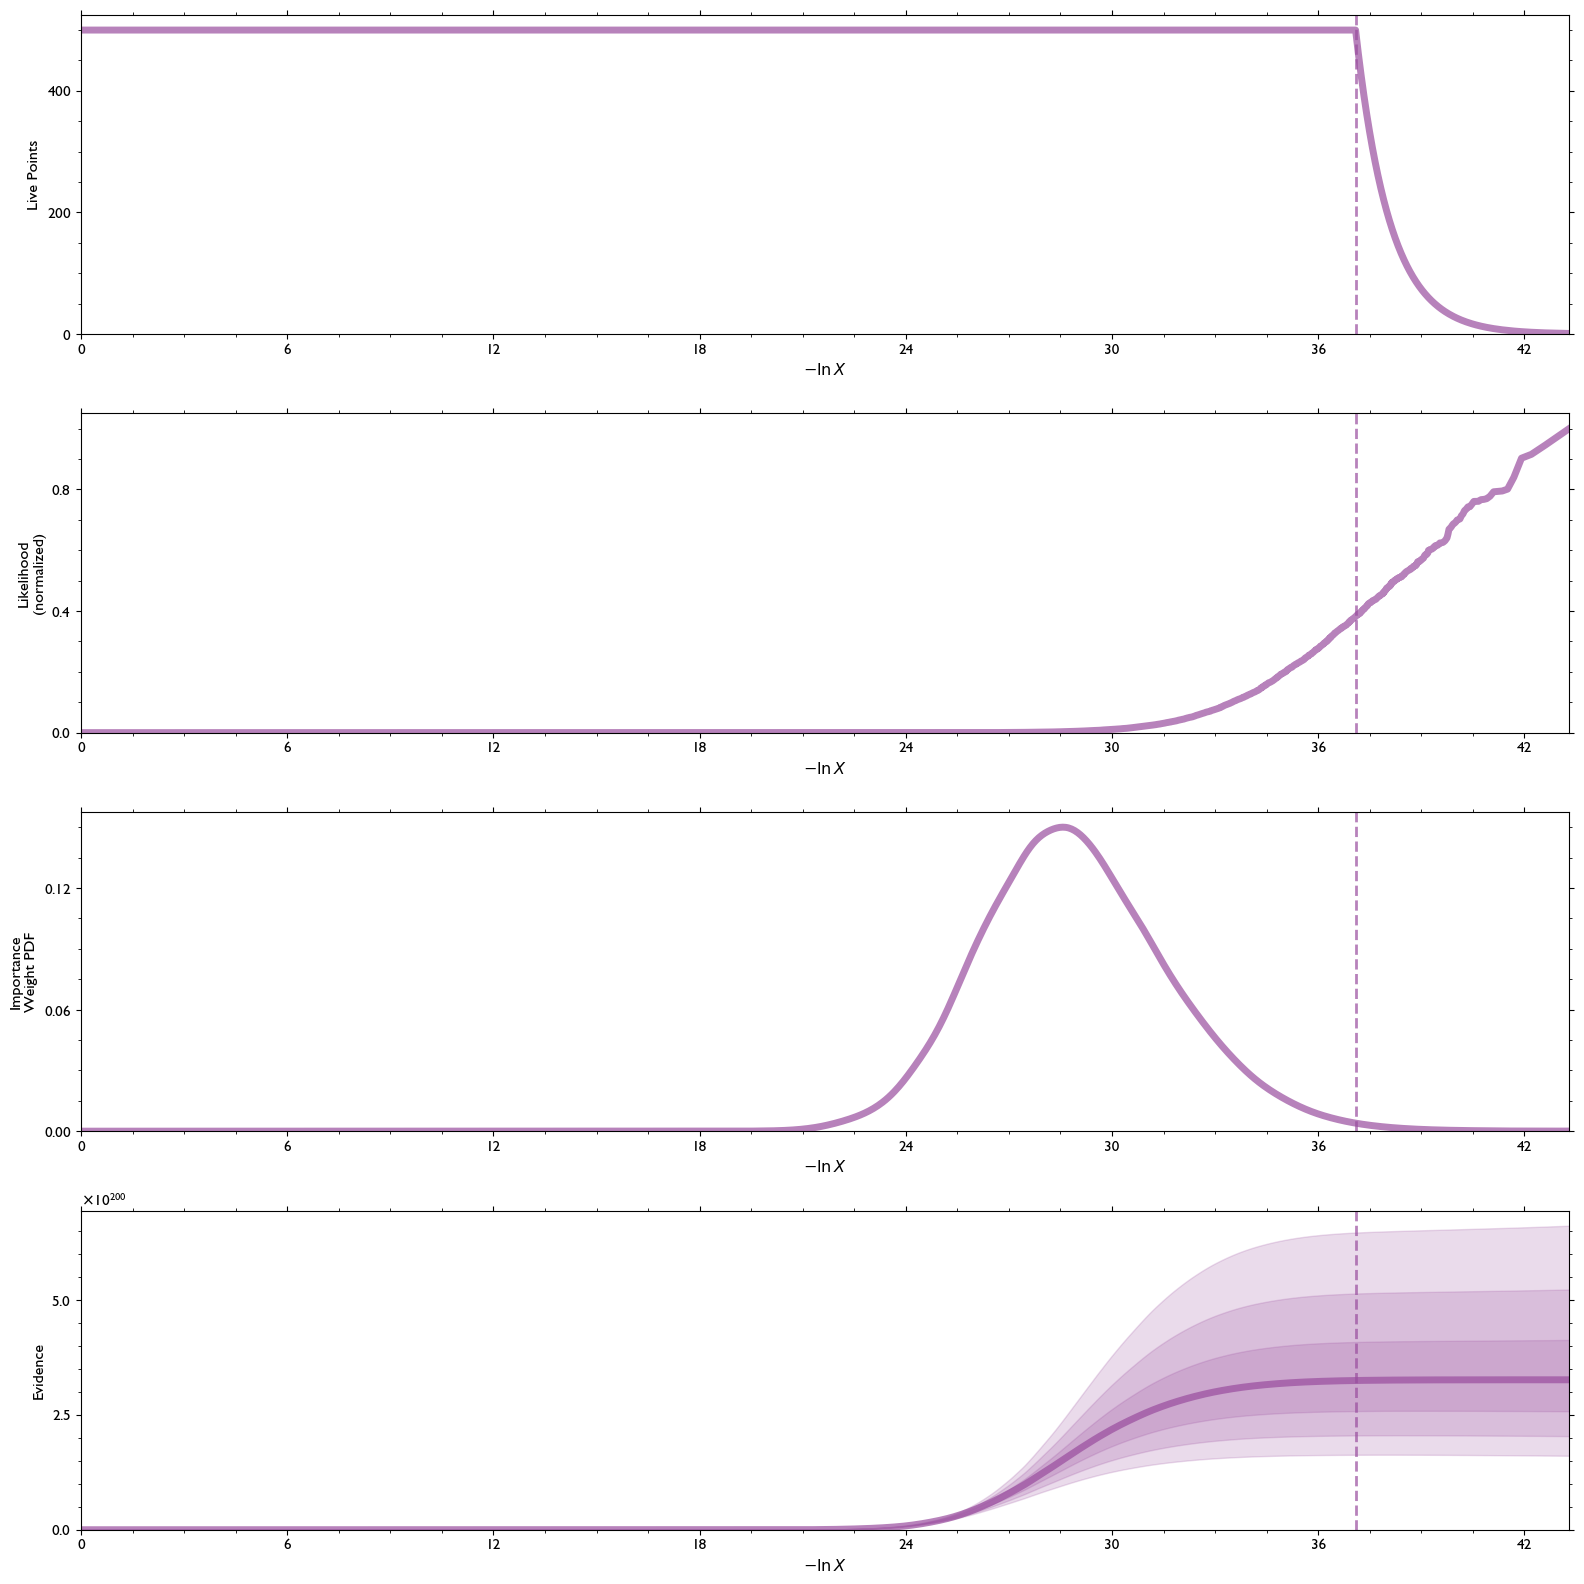

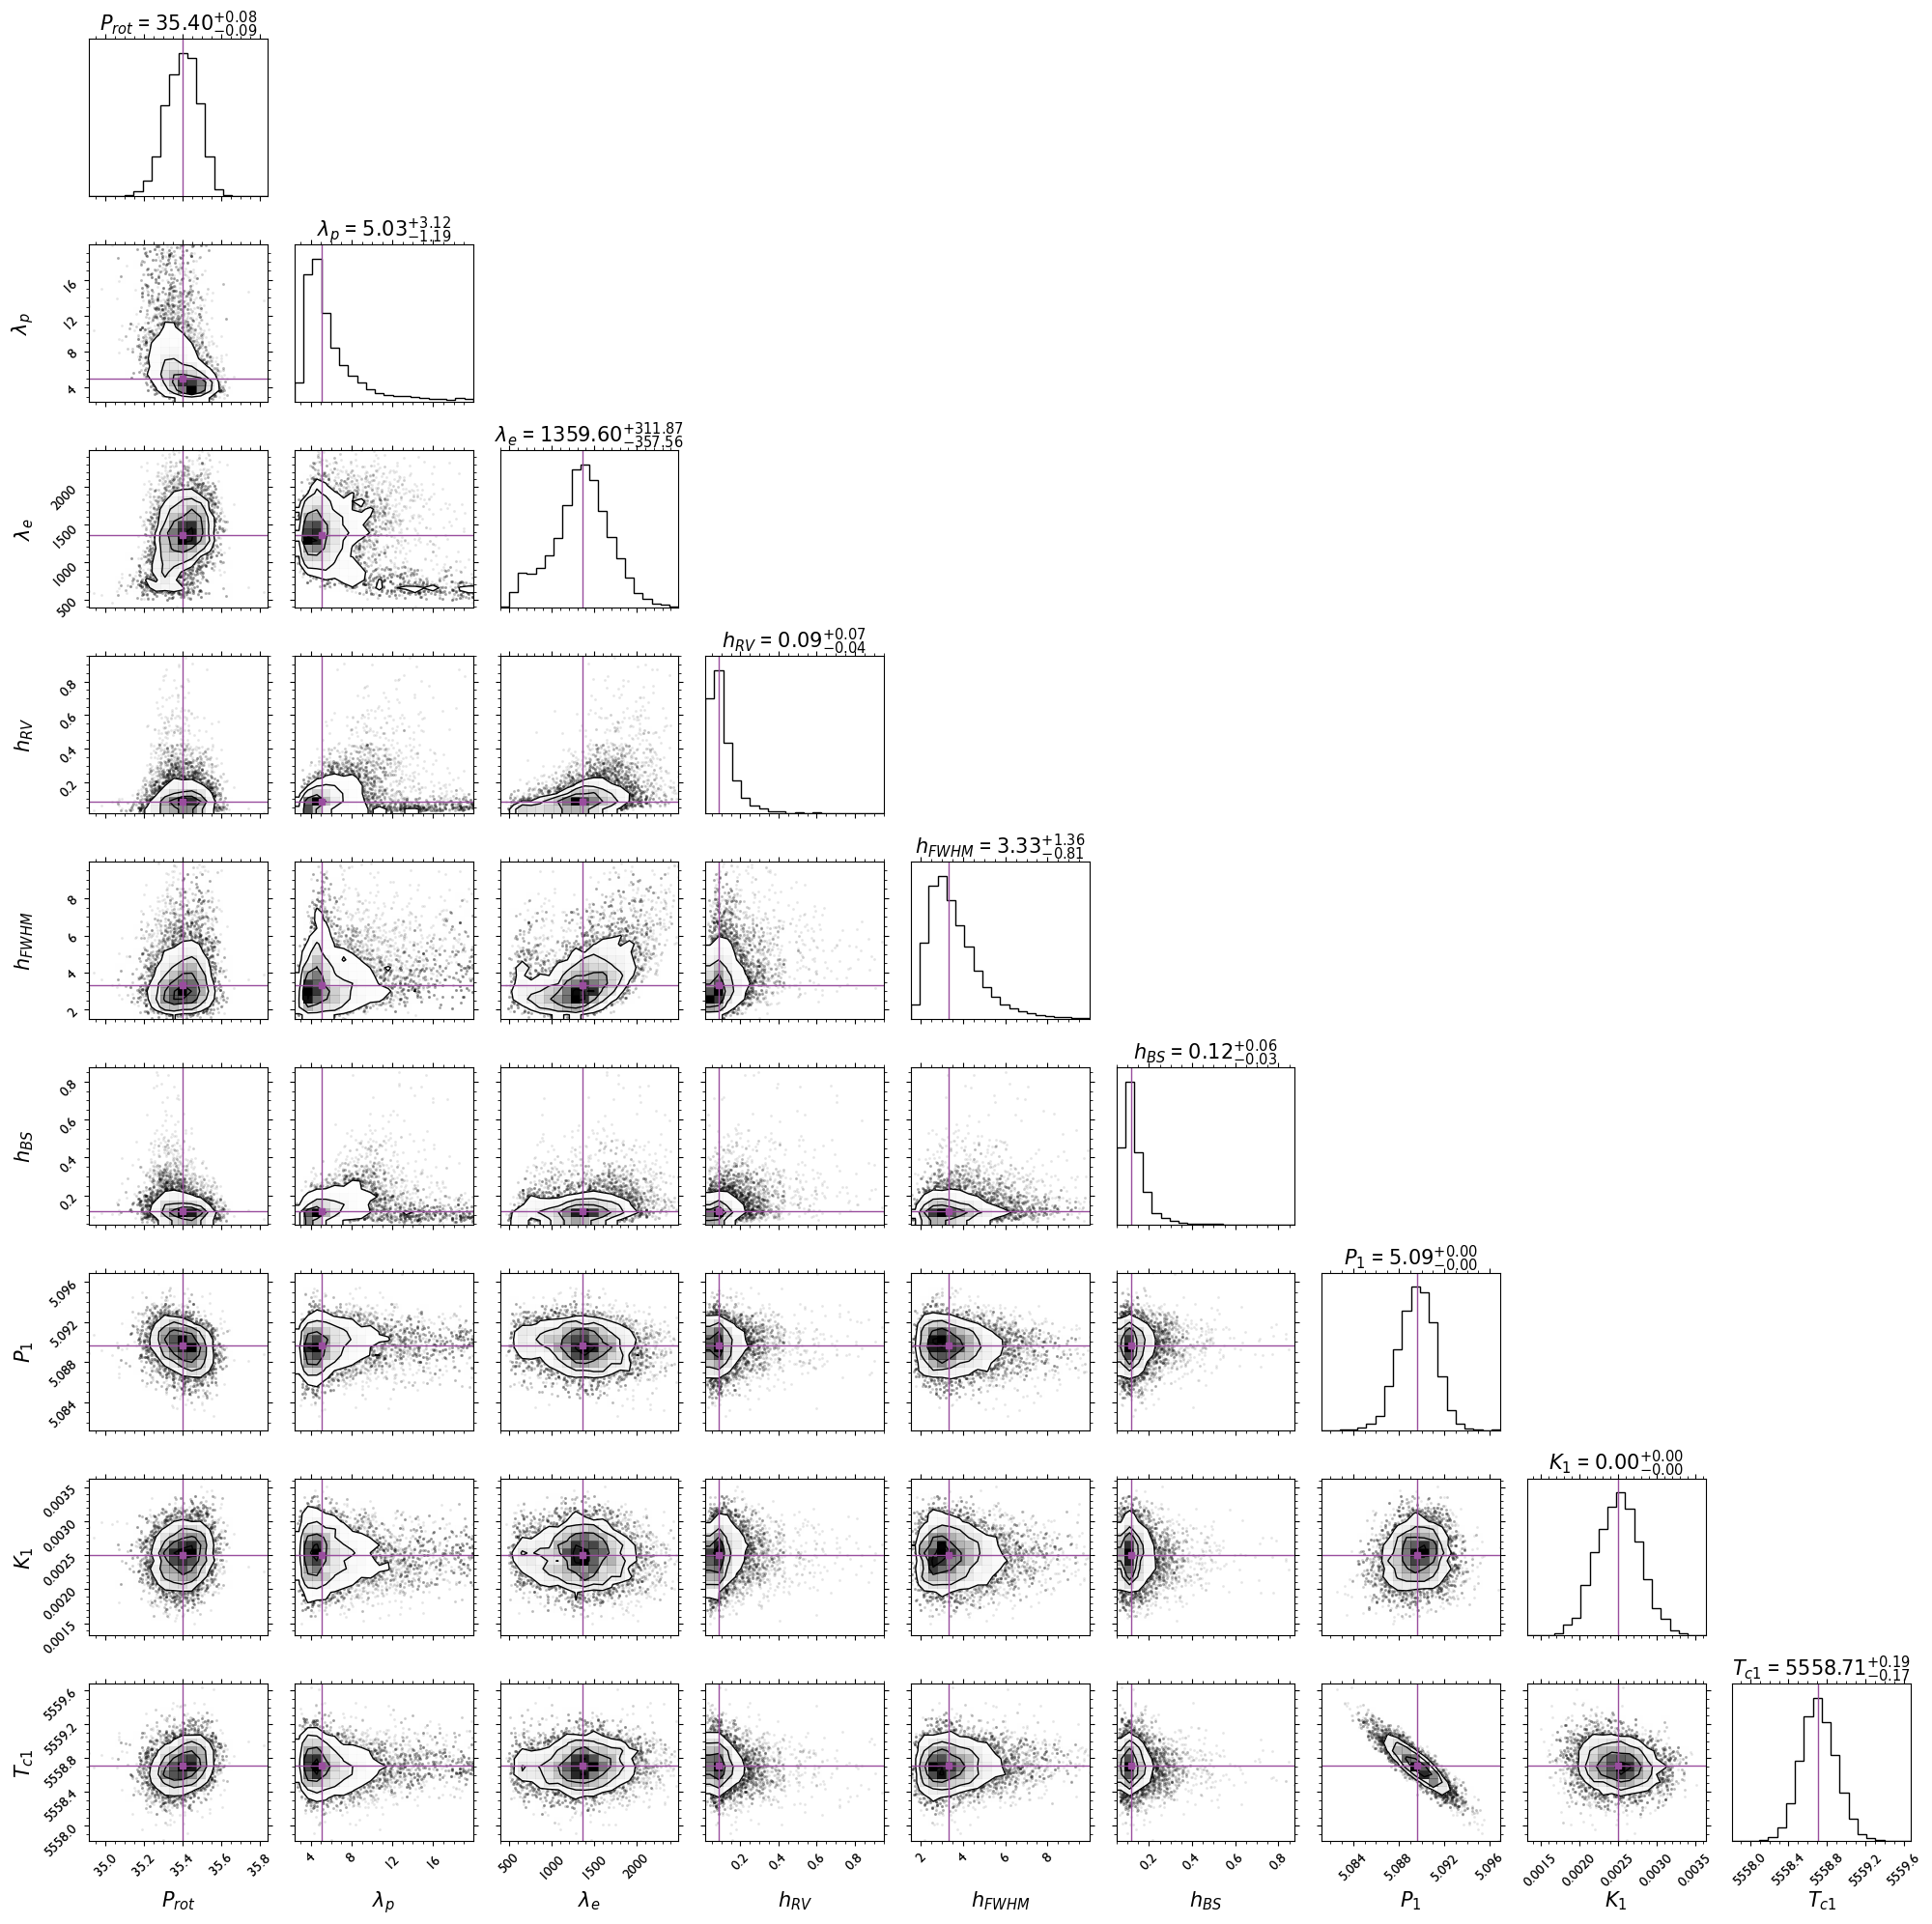

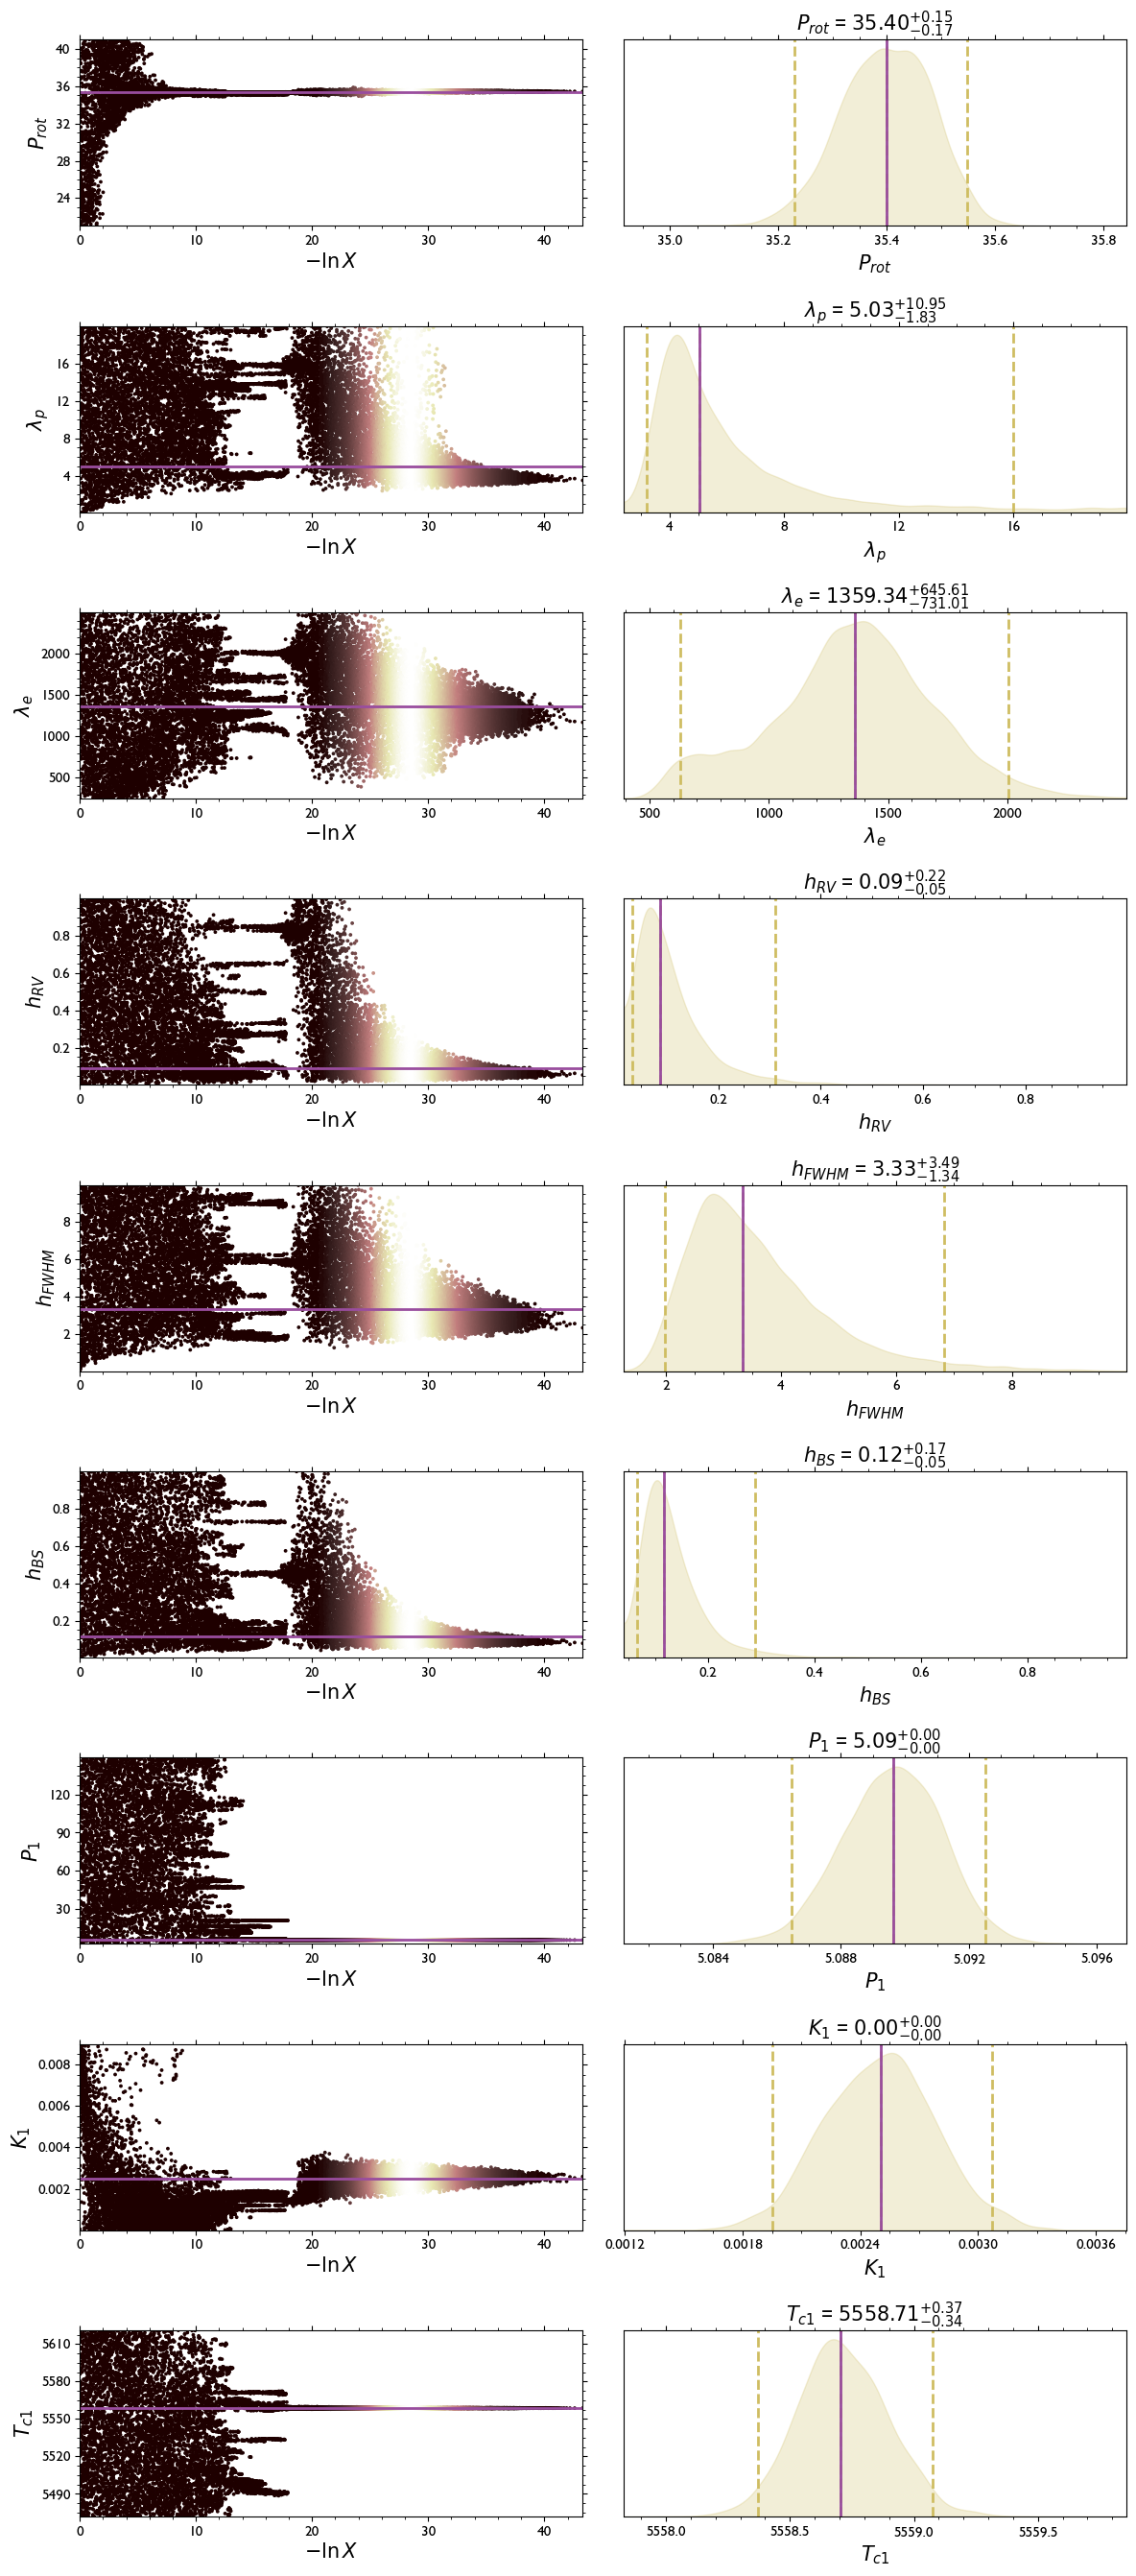

/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:345: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[i].plot(x_test, mean[i], 'b', lw=2, label='GP Mean', color = colors[i])
/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:347: RuntimeWarning: invalid value encountered in sqrt
  mean[i] - 1.96 * np.sqrt(variance[i]),
/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:348: RuntimeWarning: invalid value encountered in sqrt
  mean[i] + 1.96 * np.sqrt(variance[i]),


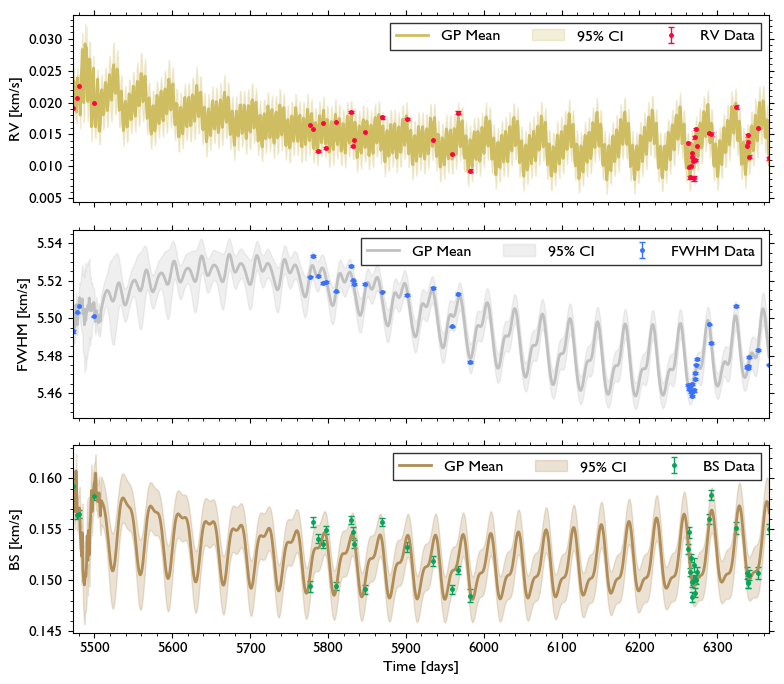

In [48]:
# === 1 Planet Model ==========================================================
print('Simplified Keplerian model run: ')
model = '1'

# Run nested sampling
sampler1 = multi_stellar_gp(time, y, yerr, params_shared_bounds, params_individual_bounds, kepler_params_bounds_1, kepler_params_bounds_2, jitters = jitters, model = model)

# Print log evidence
results1 = sampler1.results
logZ1 = results1.logz[-1]       
logZerr1 = results1.logzerr[-1] 
print(f"Log-evidence: {logZ1:.2f} +/- {logZerr1:.2f}")

# Plot the sampling results
best_fit_parameters1 = plot_stellar_gp_results(sampler1, get_value='median', cmap = 'pink', truth_color=sd2022_purple, corner_color='k', alpha = 0.25, run_color = sd2022_purple, post_color = sd2022_gold, model=model)
params_shared1= best_fit_parameters1[:3]
params_individual1 = best_fit_parameters1[3:]
keplerian_params1 = best_fit_parameters1[6:]

# Plot the prediction
jitters = np.array([1e-6, 1e-5, 1e-6])
time_pred = np.linspace(time.min(), time.max(), 1000)
mean, variance = gp_predict(time, y, time_pred, params_shared1, params_individual1, jitters, model, keplerian_params1)
plot_gp_predict(time, y, yerr, time_pred, mean, variance, colors_data = [sd2022_red, sd2022_blue, sd2022_green], colors = [sd2022_gold, sd2022_silver, sd2022_bronze], alpha = 0.25)

Simplified Keplerian model run: 
Running Nested Sampling for 2 planets...


24920it [08:11, 50.75it/s, +500 | bound: 332 | nc: 1 | ncall: 756123 | eff(%):  3.364 | loglstar:   -inf < 501.964 <    inf | logz: 456.775 +/-  0.273 | dlogz:  0.000 >  0.010]


Log-evidence: 456.78 +/- 0.28
Weighted Mean: [3.53991132e+01 8.17784387e+00 1.24187514e+03 6.95462642e-02
 3.73463465e+00 1.43076143e-01 5.08924034e+00 2.46743202e-03
 5.53331786e+03 4.91028227e+02 3.17109057e-03 6.23157269e+03]
Weighted Standard Deviation: [8.63653153e-02 4.25524827e+00 4.20227610e+02 5.16764778e-02
 1.28048811e+00 7.28794298e-02 2.12340904e-03 2.64781935e-04
 6.96642480e-01 6.59470276e+01 1.21044935e-03 3.57288279e+01]
MAP Estimate: [3.54408298e+01 3.77011222e+00 1.36874557e+03 3.28120524e-02
 2.95817215e+00 9.13915878e-02 5.09017735e+00 2.38838693e-03
 5.53321106e+03 4.71943149e+02 3.53310989e-03 6.22267178e+03]
$P_{rot}$ = 35.40027 with 68% credible interval [-0.08674, +0.08545] and 95% credible interval [-0.17862, +0.16070]
$\lambda_p$ = 6.81684 with 68% credible interval [-2.49957, +6.07435] and 95% credible interval [-3.34870, +11.71280]
$\lambda_e$ = 1293.38014 with 68% credible interval [-590.51404, +374.11601] and 95% credible interval [-747.08726, +704.66931

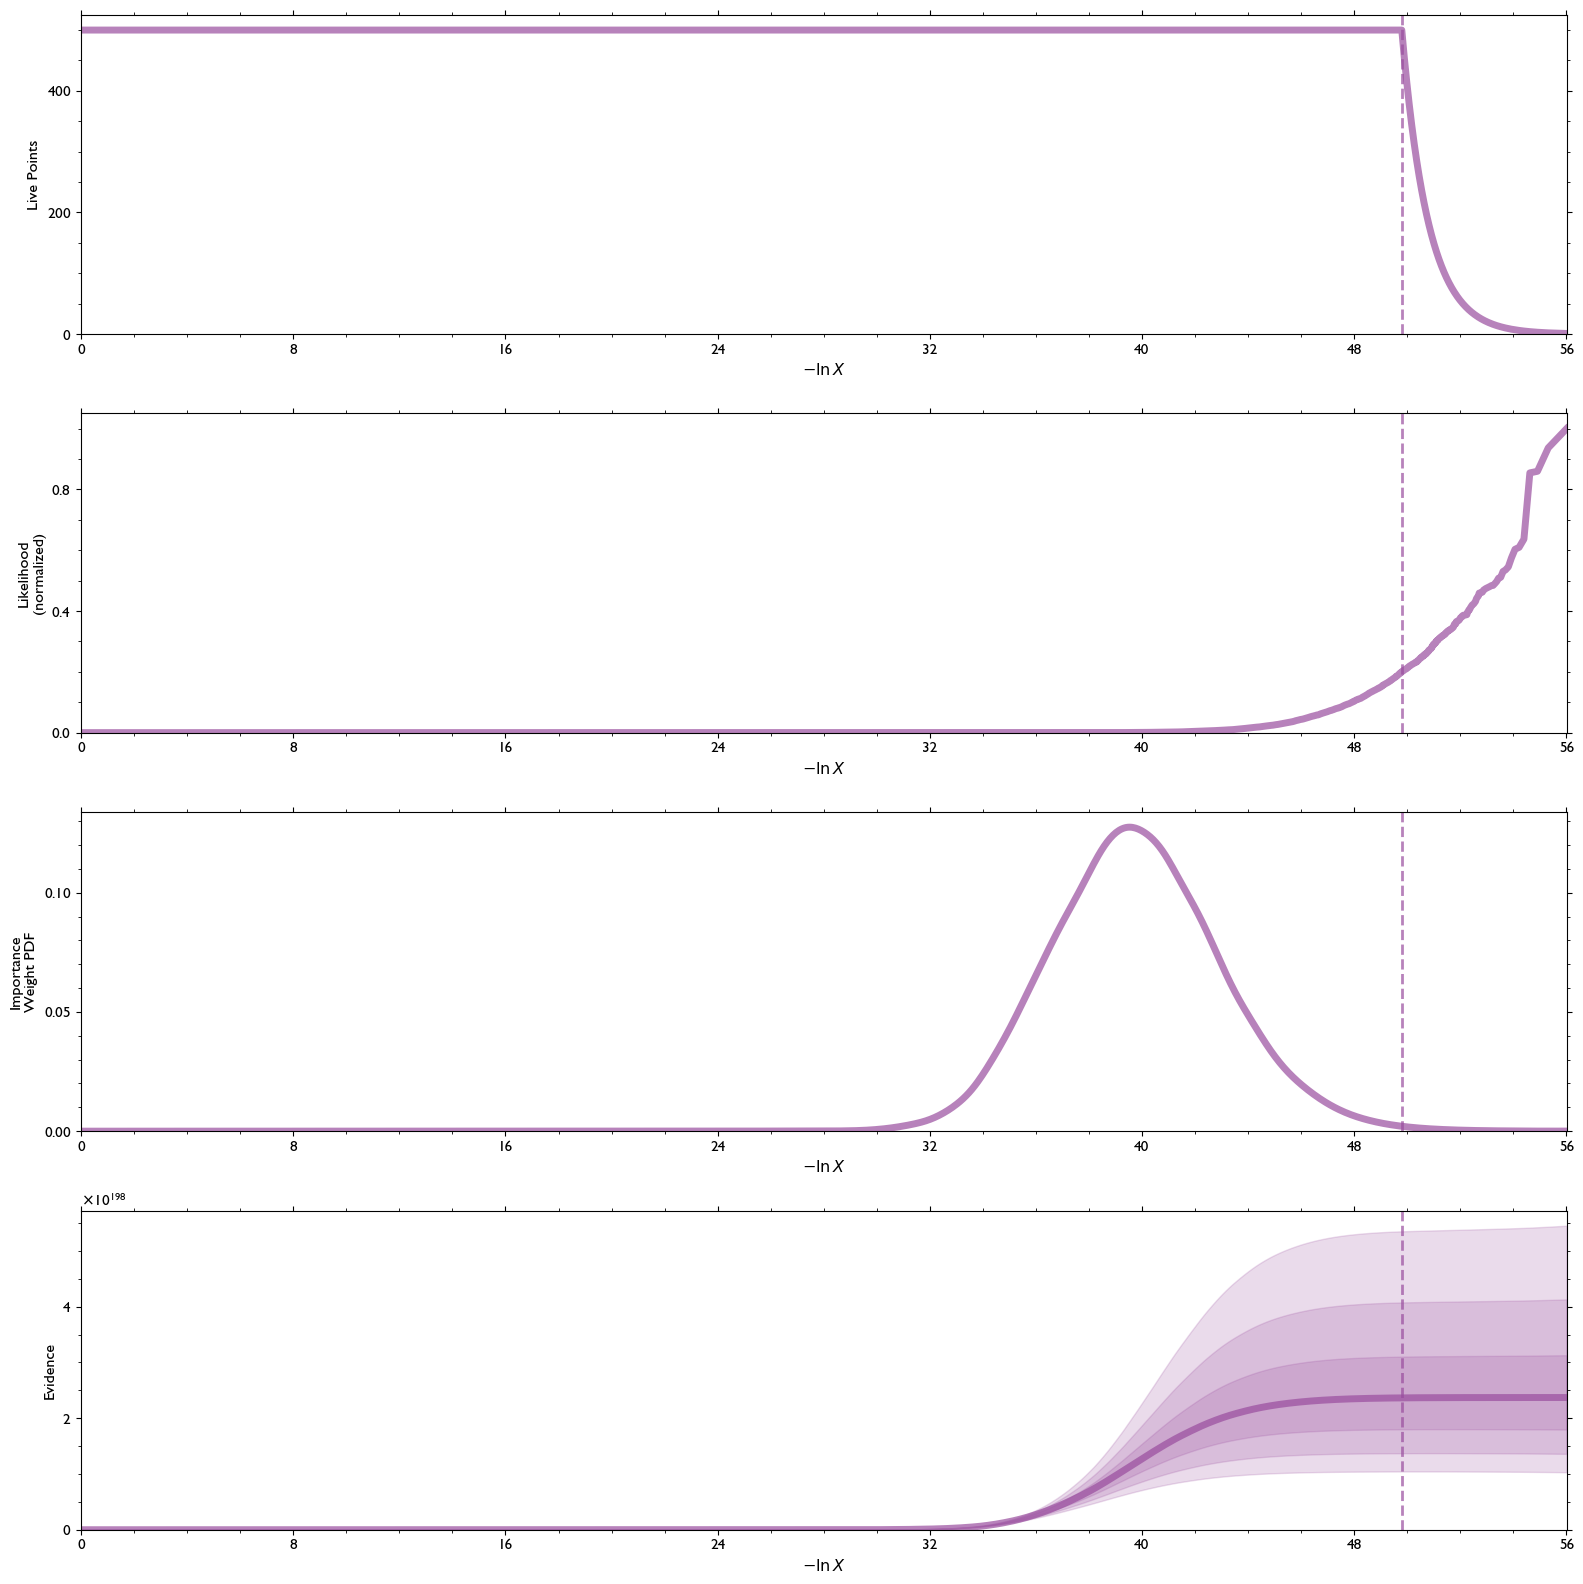

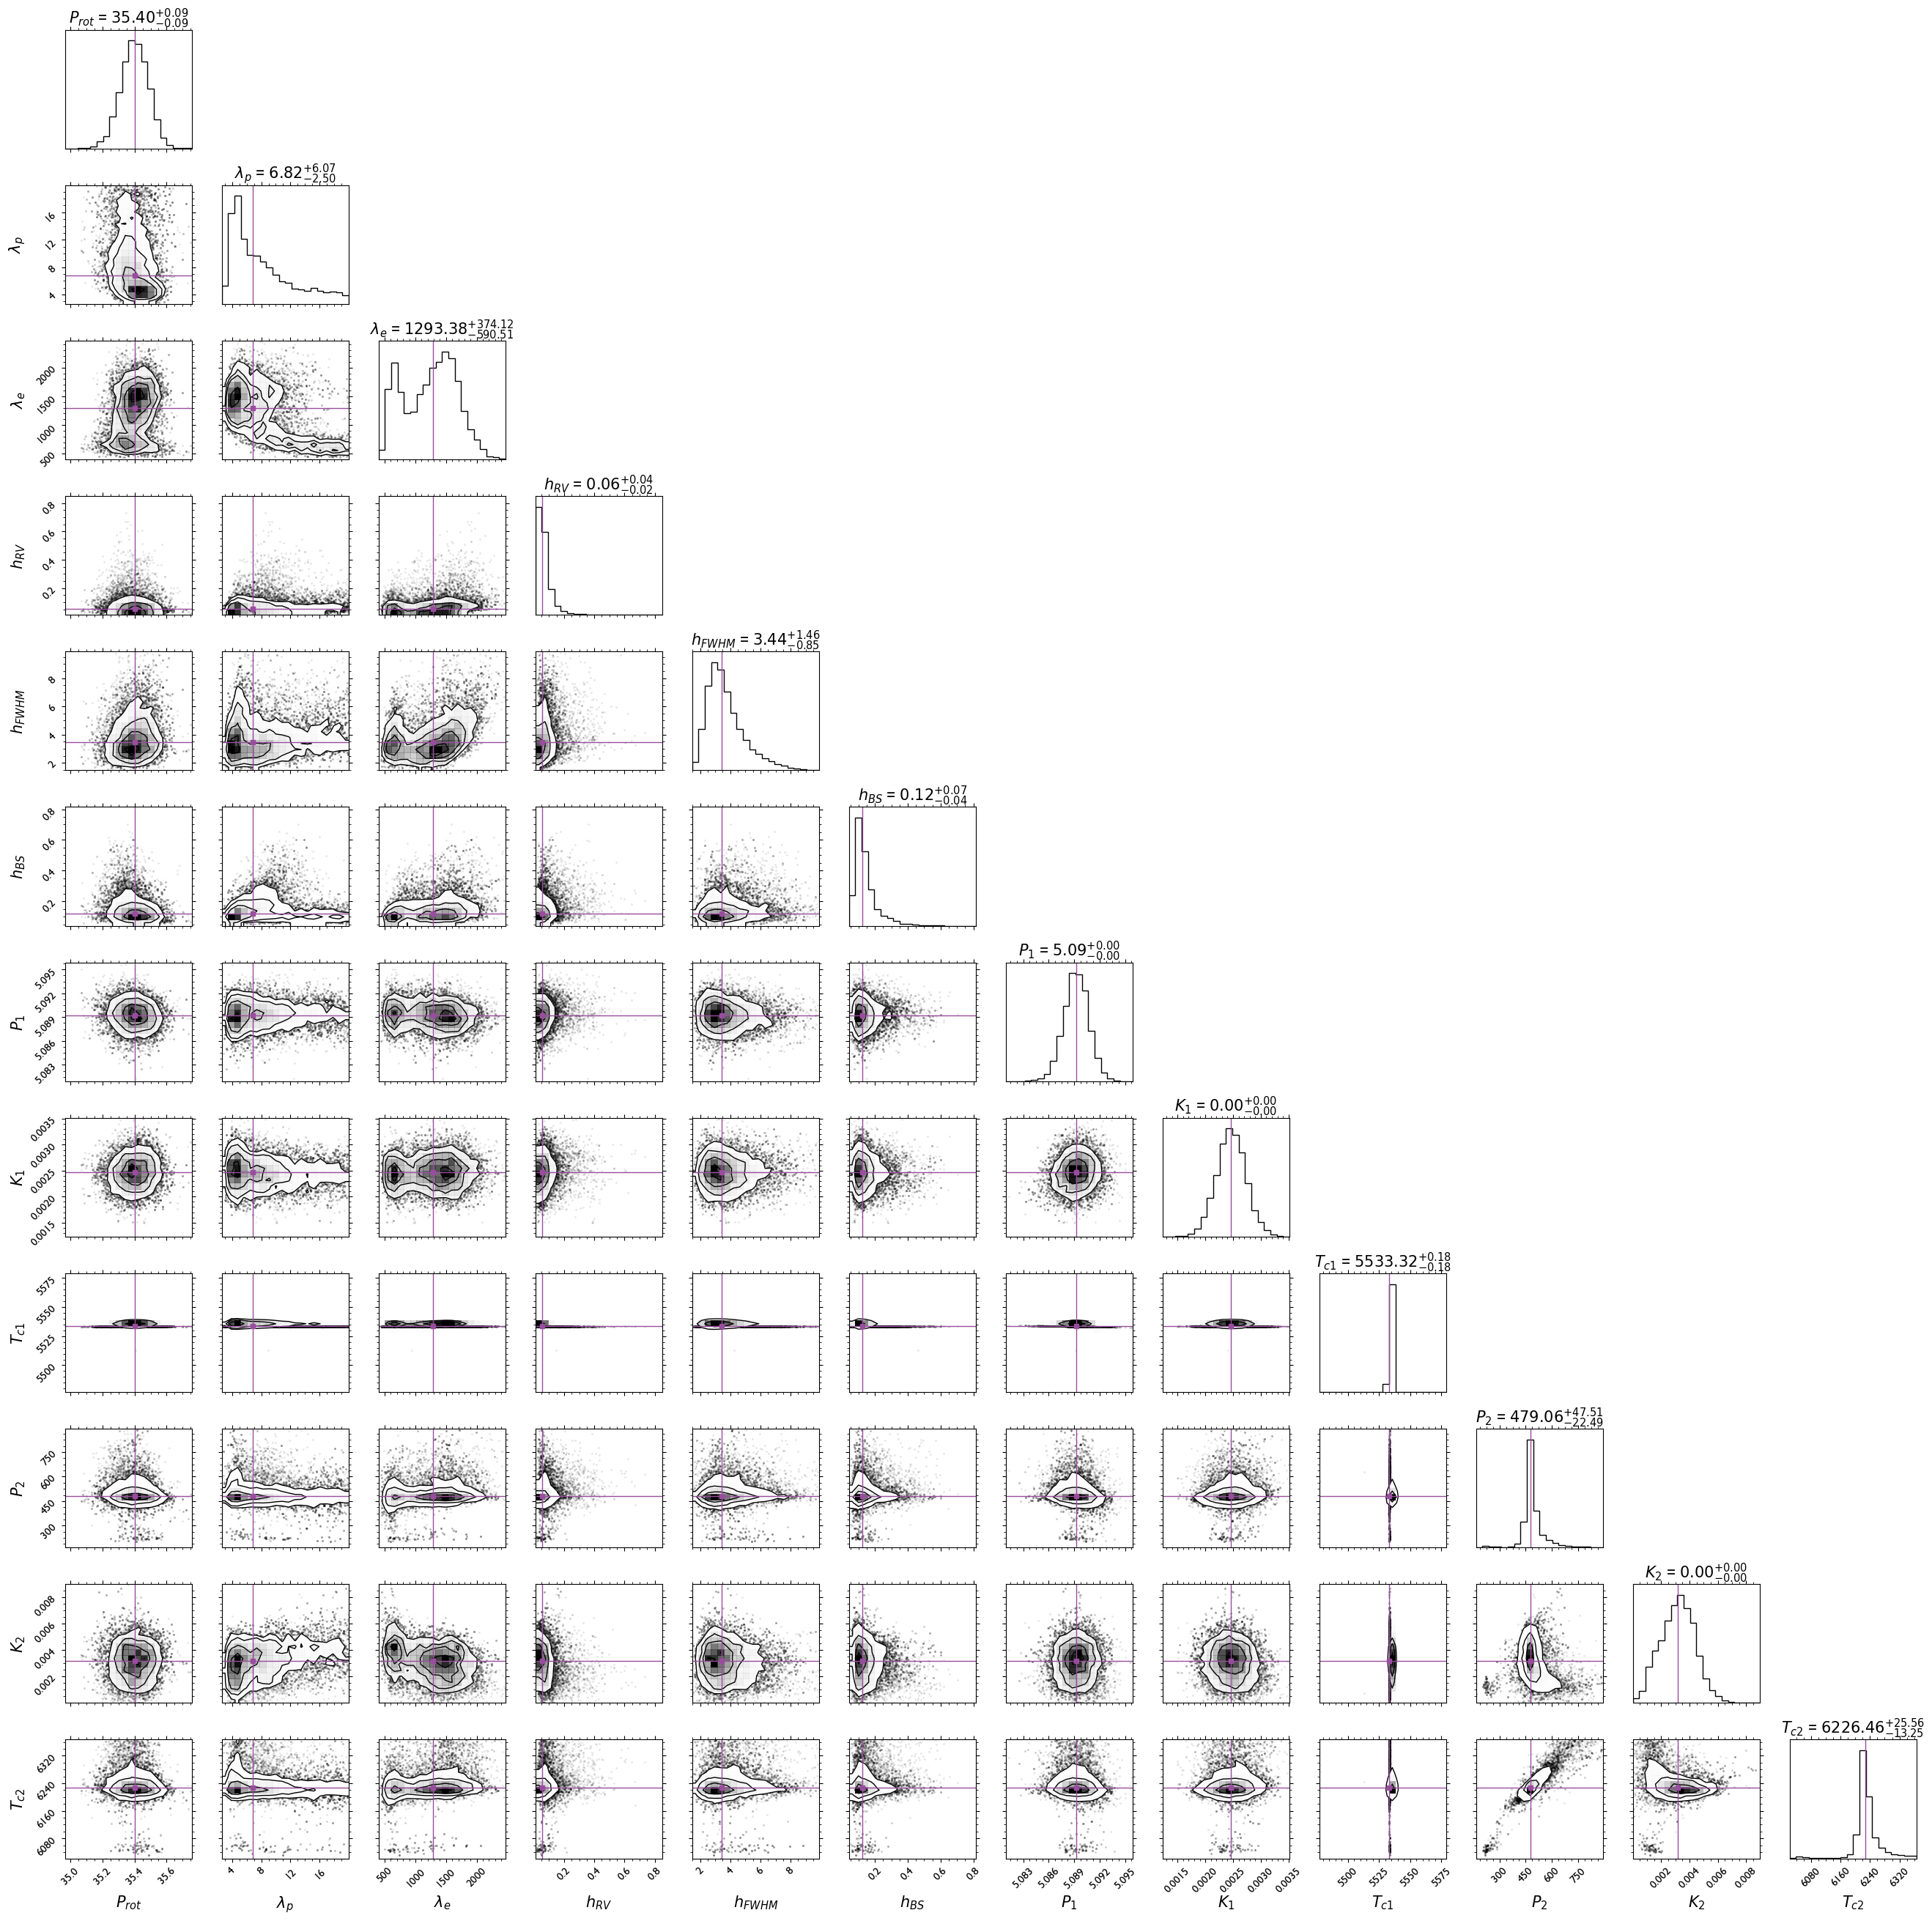

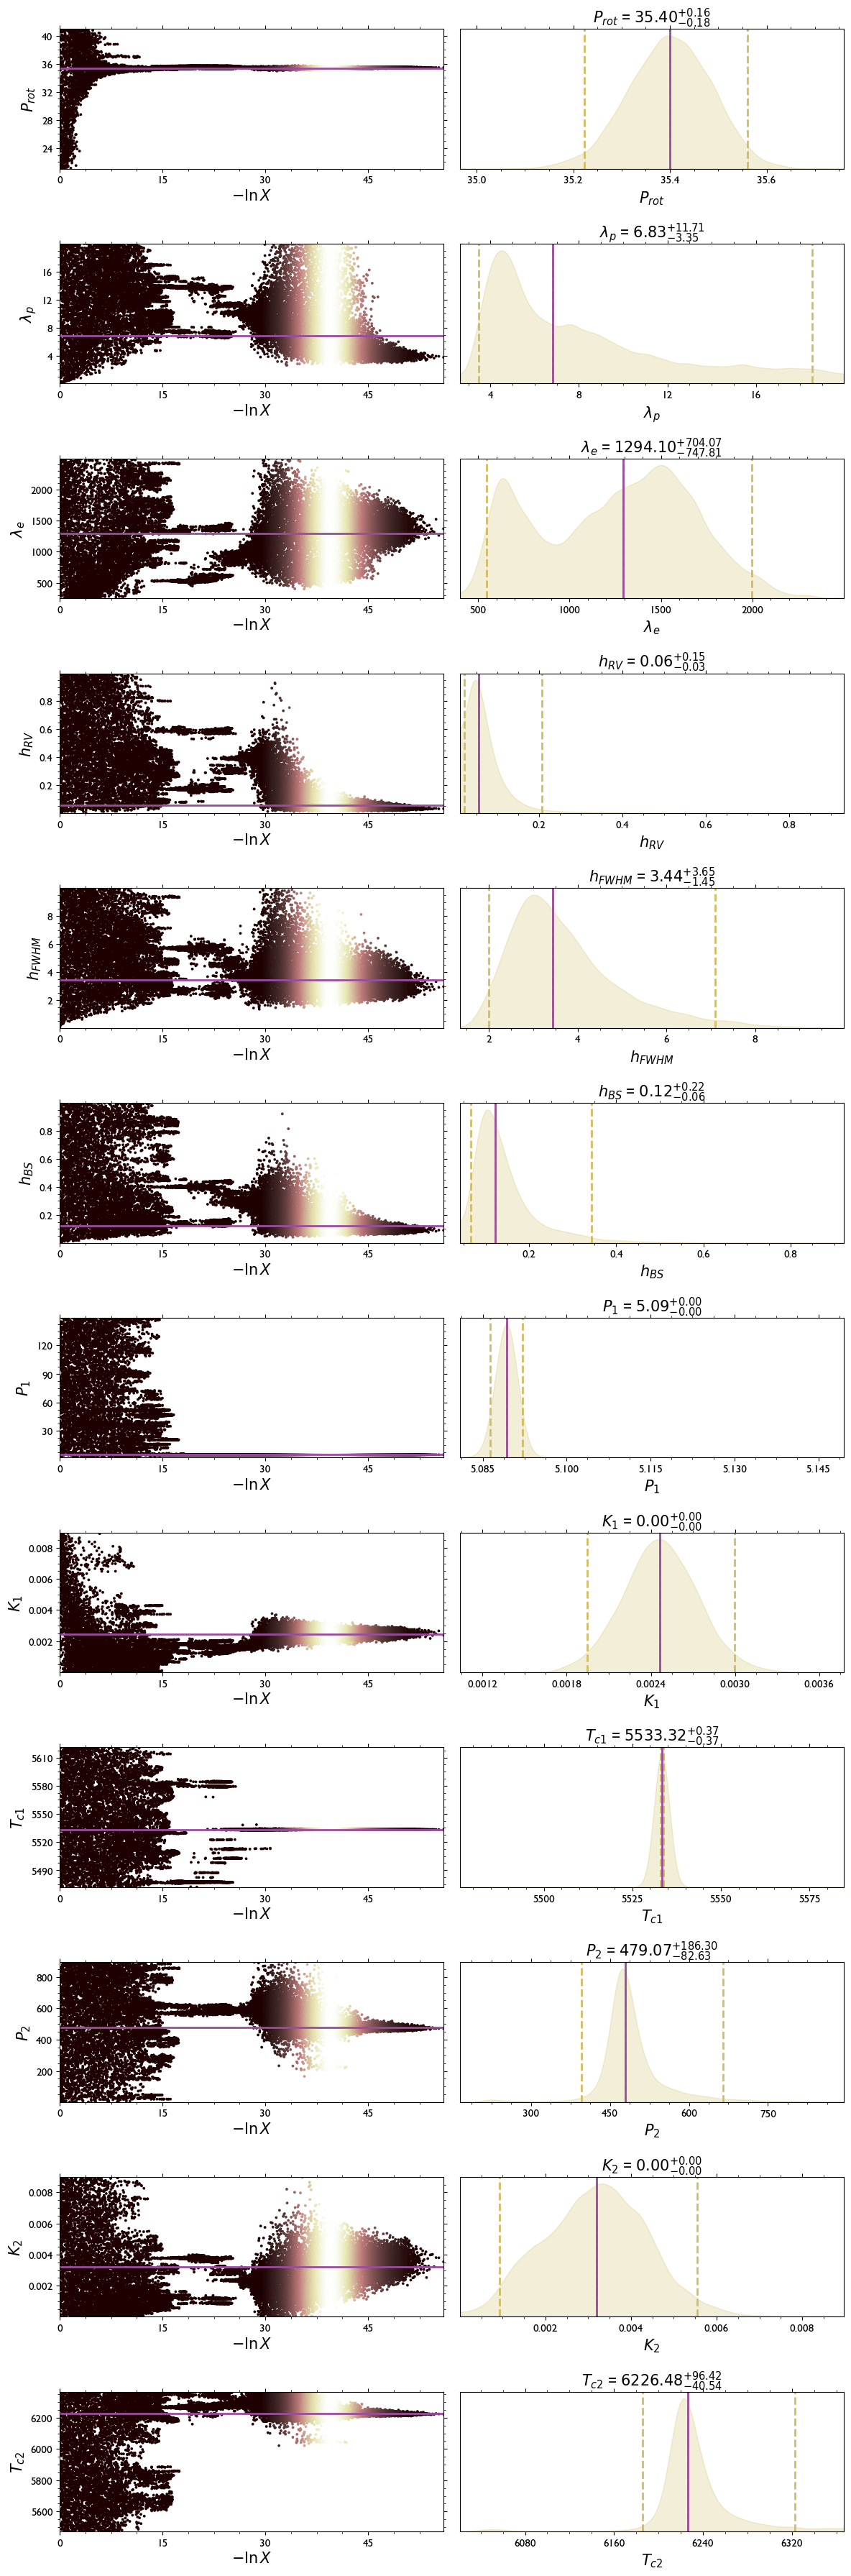

/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:345: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[i].plot(x_test, mean[i], 'b', lw=2, label='GP Mean', color = colors[i])
/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:347: RuntimeWarning: invalid value encountered in sqrt
  mean[i] - 1.96 * np.sqrt(variance[i]),
/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:348: RuntimeWarning: invalid value encountered in sqrt
  mean[i] + 1.96 * np.sqrt(variance[i]),


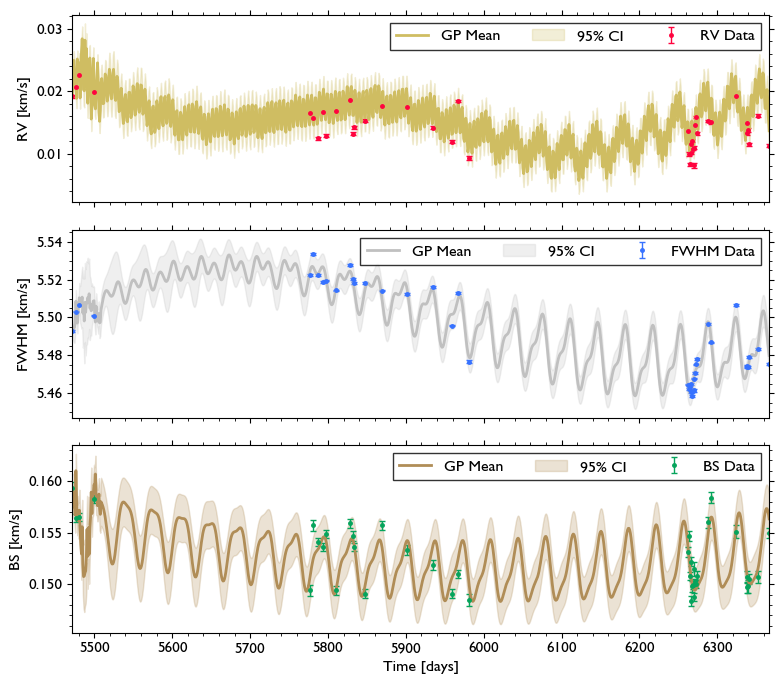

In [49]:
# === 2 Planet Model ==========================================================

print('Simplified Keplerian model run: ')
model = '2'

# Run nested sampling
sampler2 = multi_stellar_gp(time, y, yerr, params_shared_bounds, params_individual_bounds, kepler_params_bounds_1, kepler_params_bounds_2, jitters = jitters, model = model)

# Print log evidence
results2 = sampler2.results
logZ2 = results2.logz[-1]       
logZerr2 = results2.logzerr[-1] 
print(f"Log-evidence: {logZ2:.2f} +/- {logZerr2:.2f}")

# Plot the sampling results
best_fit_parameters2 = plot_stellar_gp_results(sampler2, get_value='median', cmap = 'pink', truth_color=sd2022_purple, corner_color='k', alpha = 0.25, run_color = sd2022_purple, post_color = sd2022_gold, model=model)
params_shared2 = best_fit_parameters2[:3]
params_individual2 = best_fit_parameters2[3:]
keplerian_params2 = best_fit_parameters2[6:]

# Plot the prediction
jitters = np.array([1e-6, 1e-5, 1e-6])
time_pred = np.linspace(time.min(), time.max(), 1000)
mean, variance = gp_predict(time, y, time_pred, params_shared2, params_individual2, jitters, model, keplerian_params2)
plot_gp_predict(time, y, yerr, time_pred, mean, variance, colors_data = [sd2022_red, sd2022_blue, sd2022_green], colors = [sd2022_gold, sd2022_silver, sd2022_bronze], alpha = 0.25)

In [51]:
from scipy.constants import G, astronomical_unit

def estimate_properties(P, K, e, m_star, P_err_upper, P_err_lower, K_err_upper, K_err_lower, ms_err):
    # Define constants with more significant digits
    grav_const = G  # m^3 kg^-1 s^-2
    m_sun = 1.988500e30  # kg
    m_earth = 5.97219e24  # kg
    day_seconds = 86400  # s (24*60*60)
    au =astronomical_unit # m

    # Minimum mass of the planet
    Mp_min = K * ((P * day_seconds) / (2 * np.pi * grav_const))**(1/3) * (m_star * m_sun)**(2/3) * np.sqrt(1 - e**2)
    Mp_min_earth = Mp_min / m_earth

    # Semi-major axis of the planet
    a = (grav_const * m_star * m_sun * (P * day_seconds)**2 / (4 * np.pi**2))**(1/3)
    a_au = a / au

    # Error propagation for Mp_min
    Mp_min_err_up = Mp_min * np.sqrt(
        (K_err_upper / K)**2 +
        ((1/3 * P_err_upper / P)**2) +
        ((2/3 * ms_err / m_star)**2)
    ) / m_earth
    Mp_min_err_lo = Mp_min * np.sqrt(
        (K_err_lower / K)**2 +
        ((1/3 * P_err_lower / P)**2) +
        ((2/3 * ms_err / m_star)**2)
    ) / m_earth

    # Error propagation for a
    a_err_up = a * np.sqrt(
        ((2/3 * P_err_upper / P)**2) +
        ((1/3 * ms_err / m_star)**2)
    ) / au
    a_err_lo = a * np.sqrt(
        ((2/3 * P_err_lower / P)**2) +
        ((1/3 * ms_err / m_star)**2)
    ) / au

    results = {
        'Mp_min': Mp_min,
        'Mp_min_earth': Mp_min_earth,
        'Mp_min_err_up': Mp_min_err_up,
        'Mp_min_err_lo': Mp_min_err_lo,
        'a': a,
        'a_au': a_au,
        'a_err_up': a_err_up,
        'a_err_lo': a_err_lo
    }

    # Print results
    print(f"Minimum mass of the planet: {Mp_min:.2e} kg ({Mp_min_earth:.2f} Earth masses)")
    print(f"Error: +{Mp_min_err_up:.2e} Earth masses, -{Mp_min_err_lo:.2e} Earth masses")
    print(f"Semi-major axis of the planet: {a:.2e} m ({a_au:.2f} AU)")
    print(f"Error: +{a_err_up:.2e} AU, -{a_err_lo:.2e} AU")

    return results

# Estimate the properties of the planet
m_star = 0.69 # Stellar mass in solar masses
ms_err = 0.01 # Stellar mass error in solar masses
per = 5.09
per_err_upper = 0.01
per_err_lower = 0.02
K = 2.5 # Semi-amplitude in m/s
K_err_upper = 0.27 # Upper bound of the semi-amplitude error
K_err_lower = 0.29 # Lower bound of the semi-amplitude error
e = 0 # Eccentricity


results = estimate_properties(per, K, e, m_star, per_err_upper, per_err_lower, K_err_upper, K_err_lower, ms_err)

print(results)

Minimum mass of the planet: 3.14e+25 kg (5.25 Earth masses)
Error: +5.69e-01 Earth masses, -6.11e-01 Earth masses
Semi-major axis of the planet: 7.66e+09 m (0.05 AU)
Error: +2.56e-04 AU, -2.81e-04 AU
{'Mp_min': 3.136209819847873e+25, 'Mp_min_earth': 5.251356403342615, 'Mp_min_err_up': 0.5694218894578998, 'Mp_min_err_lo': 0.6113054014034747, 'a': 7655282833.8904915, 'a_au': 0.05117240504874707, 'a_err_up': 0.00025613428506300406, 'a_err_lo': 0.0002812137995321762}
